## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import Packages
import glob  # OS dependencies to get file system details
import cv2
#importing some useful packages
import pickle
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def show_images(images, gray=None, divider = 2):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//divider
    plt.figure(figsize=(16, 16))
    for idx, img in enumerate(images):
        plt.subplot(rows, divider, idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()

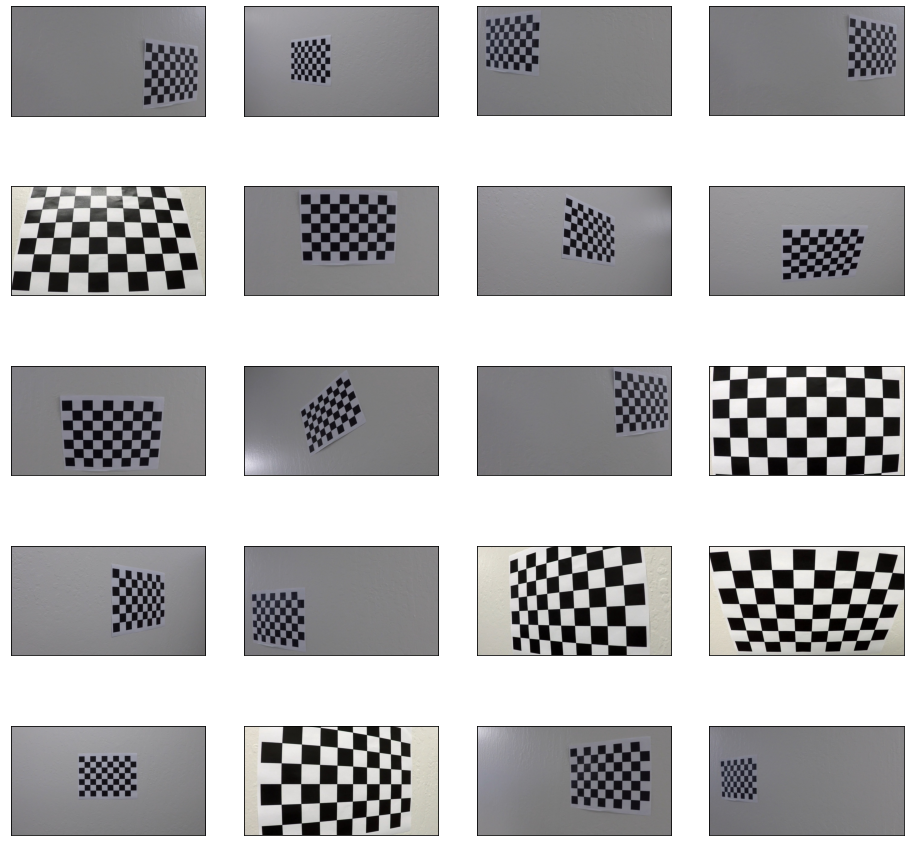

In [3]:
# Loading test images from test_image directory
camera_cal_imgs = [plt.imread(path) for path in glob.glob("camera_cal/*")]

# Visualize calibration images
show_images(camera_cal_imgs, divider=4)

In [4]:
def grayscale(img, opencv_read=False):
    """

    :param img:
    :param opencv_read:
    :return:
    """
    if opencv_read:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [5]:
# prepare objects points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

In [6]:
def find_and_draw_chessboard(img, idx,axs, pattern_size= (9,6)):
    gray = grayscale(img)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)
        
        axs[idx].axis('off')
        axs[idx].imshow(img)

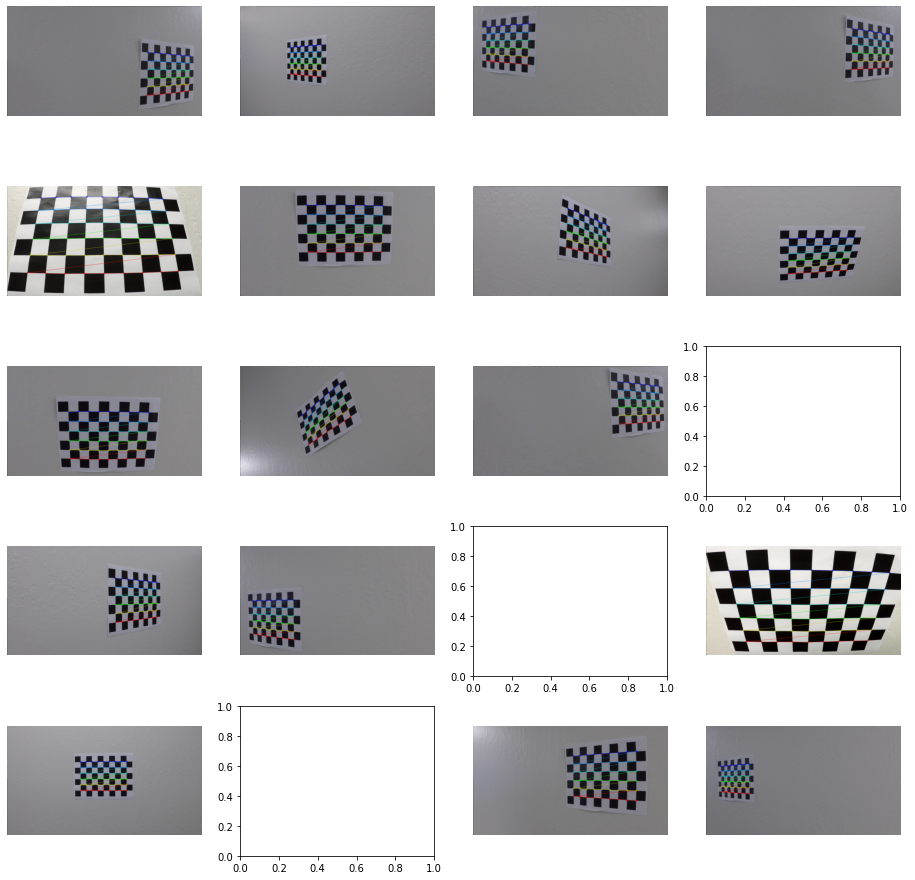

In [7]:
# Draw subplots dynamically
fig, axs = plt.subplots(5,4, figsize=(16, 16))
axs = axs.ravel()

for idx, img in enumerate(camera_cal_imgs):
    find_and_draw_chessboard(img,idx,axs)

### Calibrating Camera

In [8]:
#cache an image to further reuse
sample_img = cv2.imread("camera_cal/calibration1.jpg")
#cache image size to further reuse
img_size = sample_img.shape[:2]

# Do Camera calibration given objects' points and images' points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)

# Save the Camera calibration results for later use
dist_pickle = {"mtx": mtx, "dist": dist}
pickle.dump( dist_pickle, open( "resources/calibration.p", "wb" ) )

### Undistort Images

In [9]:
def undistort(img, mtx, dist):
    """

    :param img:
    :param mtx:
    :param dist:
    :return:
    """
    return cv2.undistort(img, mtx, dist,None, mtx)

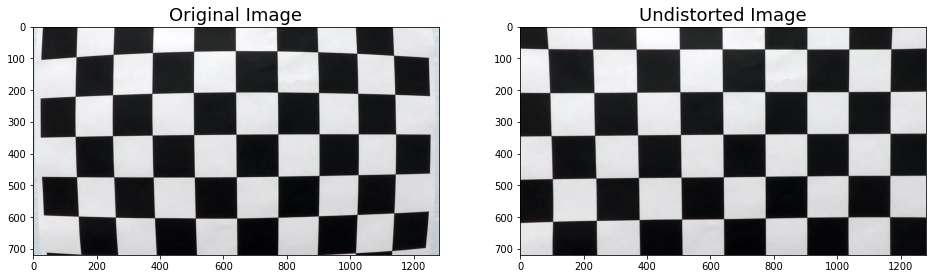

In [10]:
def undistort_image(img, cmatrix, distc ):
    """

    :param sample_img:
    :param cmatrix:
    :param distc:
    :return:
    """
    udistord_img = undistort(img, cmatrix, distc)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(udistord_img)
    ax2.set_title('Undistorted Image', fontsize=18)
    # this can be used
    return udistord_img

res = undistort_image(sample_img, mtx,dist)

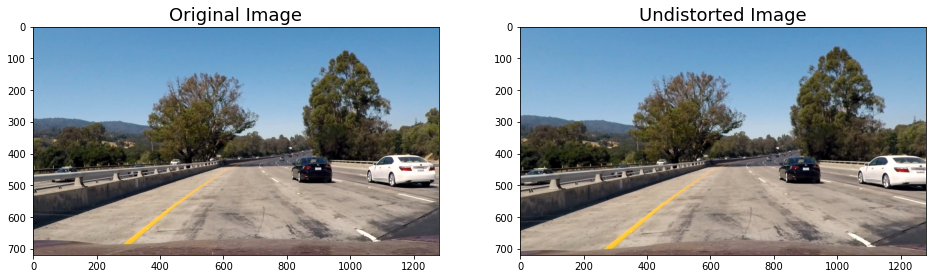

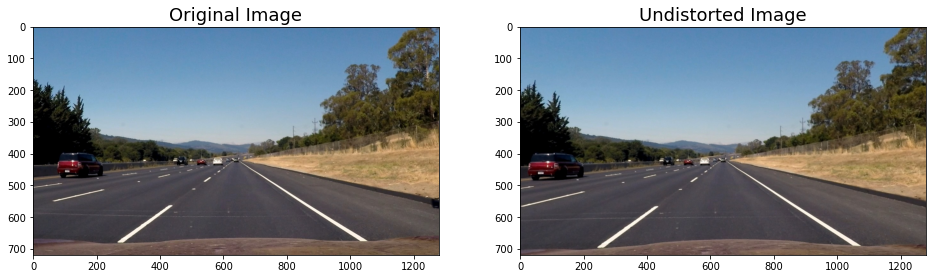

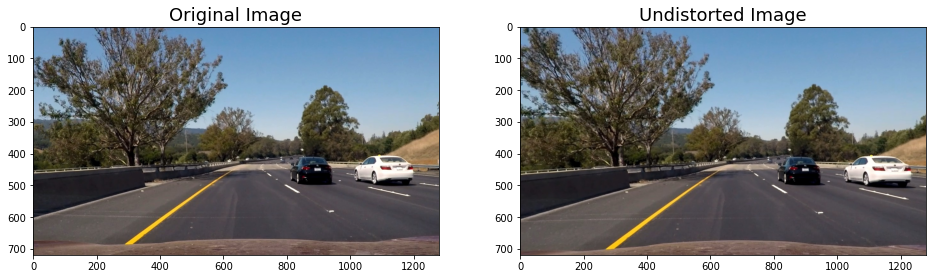

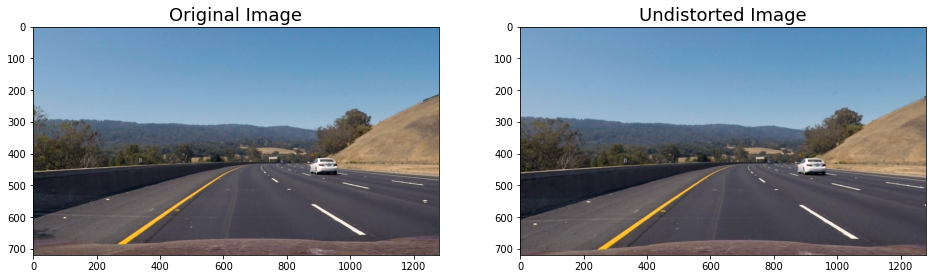

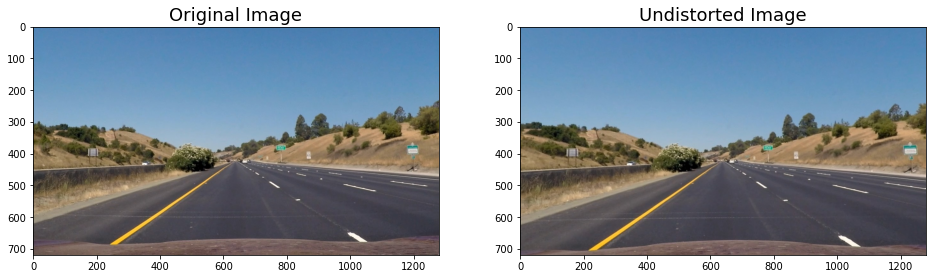

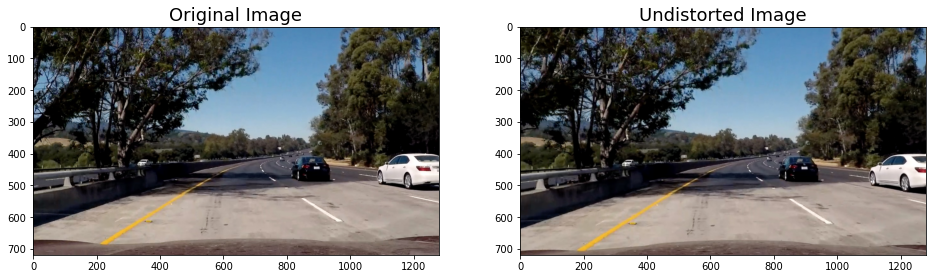

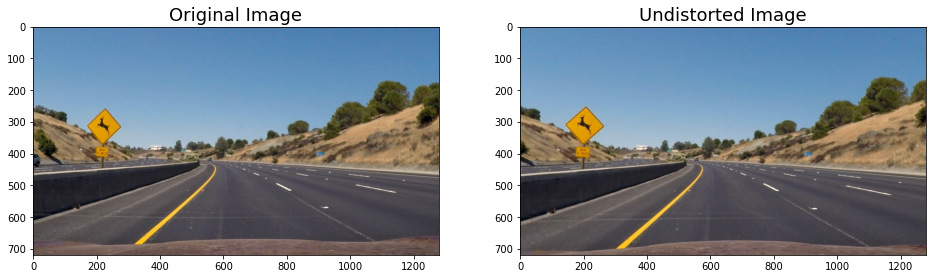

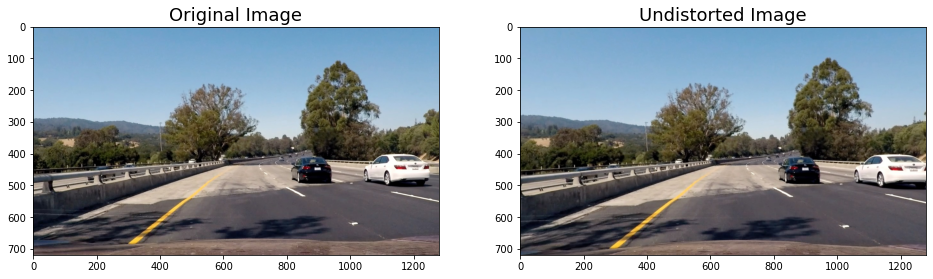

In [11]:
test_images = [plt.imread(path) for path in glob.glob("test_images/*")]

#undistord images
undistort_images = list(map(lambda img: undistort_image(img, mtx, dist), test_images))

### Perspective Transform

In [12]:
def warp(img, src, dst):
    """

    :param img: input image
    :param src: source
    :param dst: destination
    :return:
    """
    M = cv2.getPerspectiveTransform(src,dst) # magnitute
    Minv = cv2.getPerspectiveTransform(dst, src)
    h,w = img.shape[:2]
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped, Minv, M

#### Select source and destination from images

In [13]:
height, width = test_images[0].shape[:2]
# source points
p1 = (575, 465)
p2 = (705, 465)
p3 = (255, 685)
p4 = (1050, 685)
line_color = (0, 255, 0) # Green

# destination points
pd1 = (450, 0)
pd2 = (width - 450, 0)
pd3 = (450, height)
pd4 = (width - 450, height)

In [14]:
def draw_polygon_on_image(img, line_color=(0, 255,0)):
    """

    :param img:
    :return:
    """
    cv2.line(img, p1, p2, line_color, 3)
    cv2.line(img, p2, p4, line_color, 3)
    cv2.line(img, p4, p3, line_color, 3)
    cv2.line(img, p3, p1, line_color, 3)

    return  img

#### Warped source images before warp


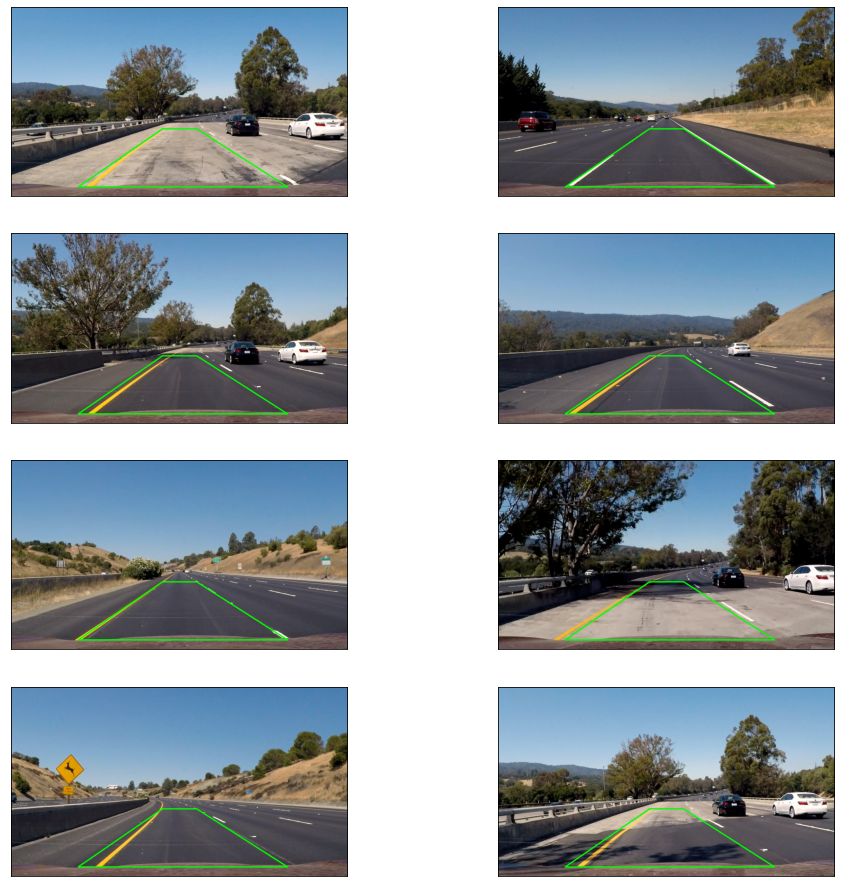

In [15]:
src_selected_images = list(map(lambda img: draw_polygon_on_image(img), test_images))
show_images(src_selected_images)

In [16]:
def visualize_warped_images(img, src, dst):
    warped, _, _ = warp(img, src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    img = draw_polygon_on_image(img)
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=18)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=18)
    return warped

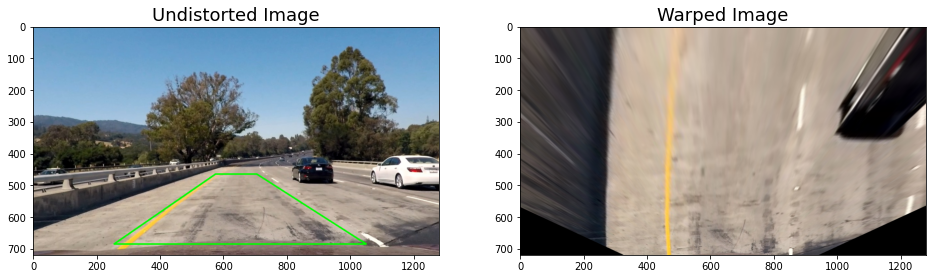

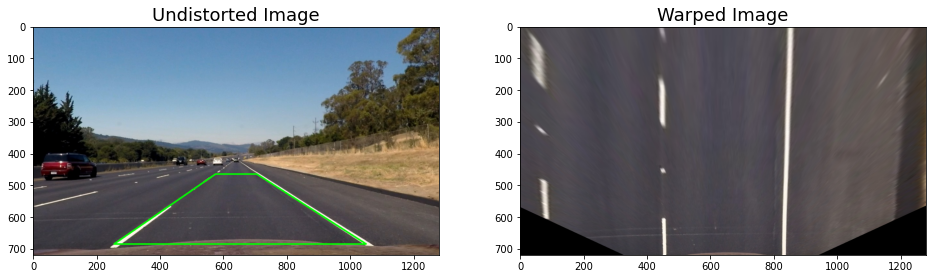

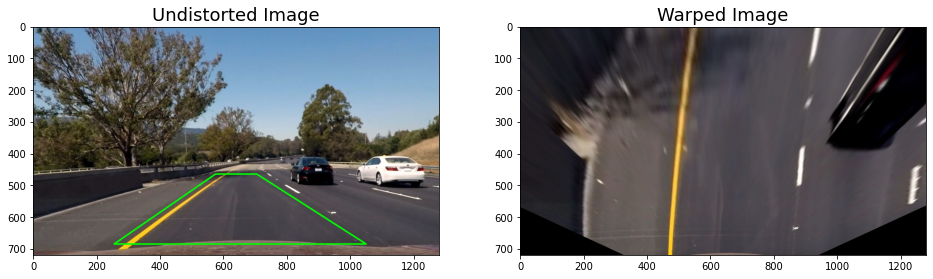

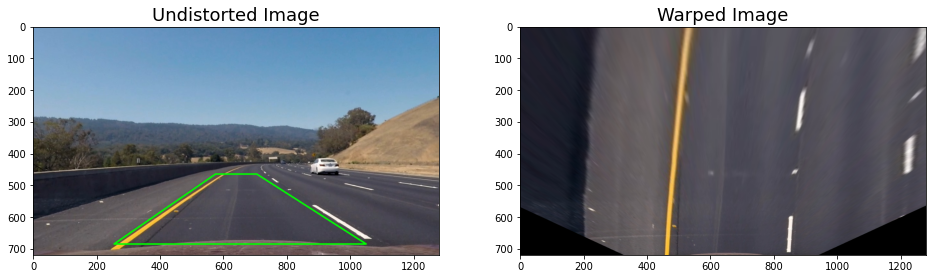

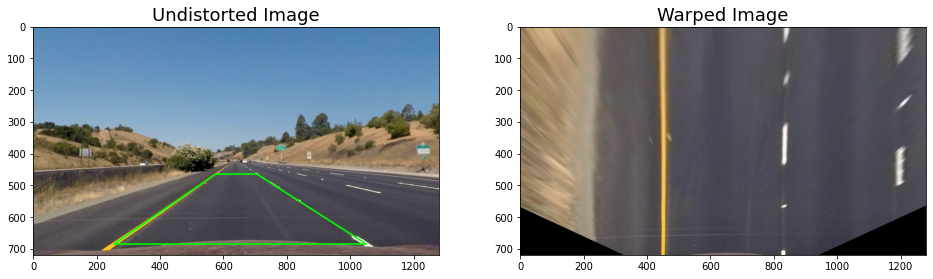

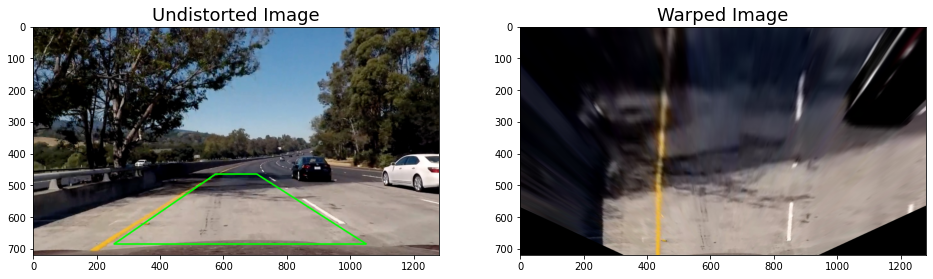

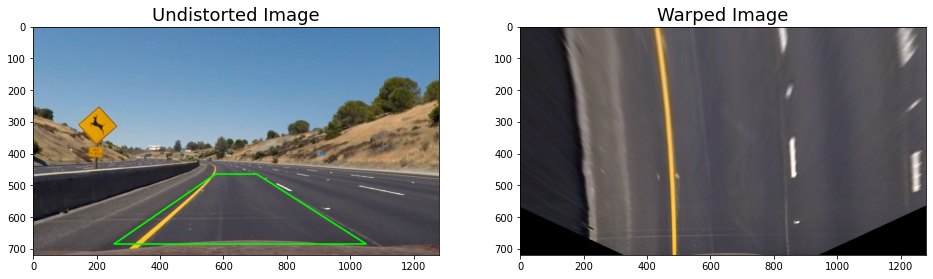

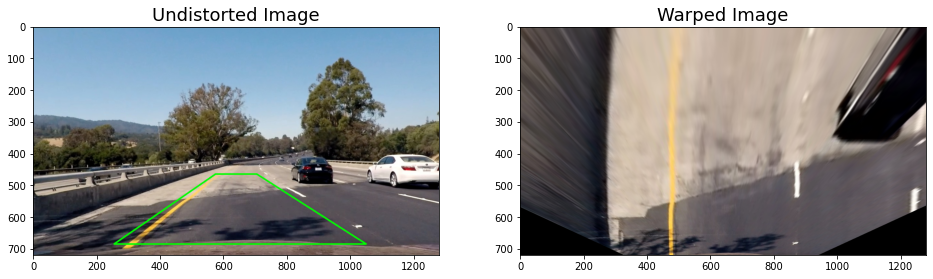

In [17]:
src = np.float32([p1, p2, p3, p4])
dst = np.float32([pd1, pd2, pd3, pd4])
#
warped_images = list(map(lambda img: visualize_warped_images(img, src, dst), undistort_images))

#### Colour channels

In [18]:
def apply_color_filter(wimg):
    warp_R = wimg[:,:,0]
    warp_G = wimg[:,:,1]
    warp_B = wimg[:,:,2]
    warp_HSV = cv2.cvtColor(wimg, cv2.COLOR_RGB2HSV)
    warp_H = warp_HSV[:,:,0]
    warp_S = warp_HSV[:,:,1]
    warp_V = warp_HSV[:,:,2]
    fig, axs = plt.subplots(1,6, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(warp_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=12)
    axs[1].imshow(warp_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=12)
    axs[2].imshow(warp_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=12)
    axs[3].imshow(warp_H, cmap='gray')
    axs[3].set_title('HSV H-Channel', fontsize=12)
    axs[4].imshow(warp_S, cmap='gray')
    axs[4].set_title('HSV S-channel', fontsize=12)
    axs[5].imshow(warp_V, cmap='gray')
    axs[5].set_title('HSV V-Channel', fontsize=12)

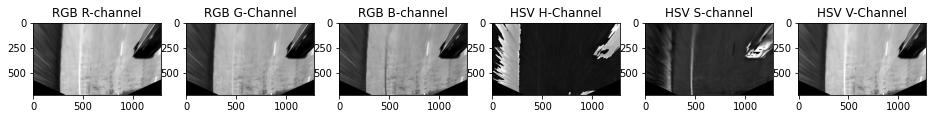

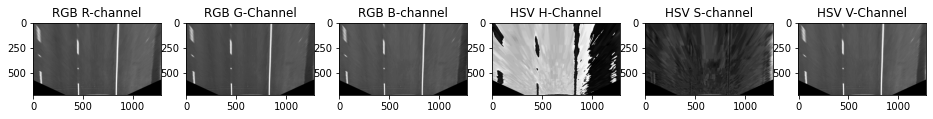

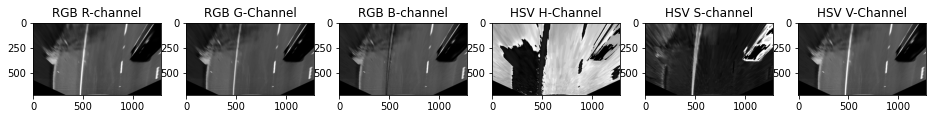

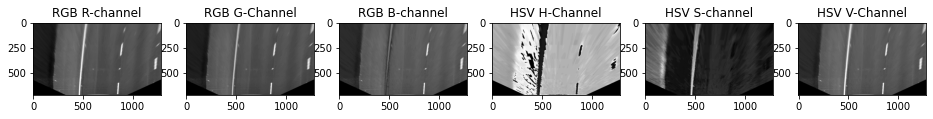

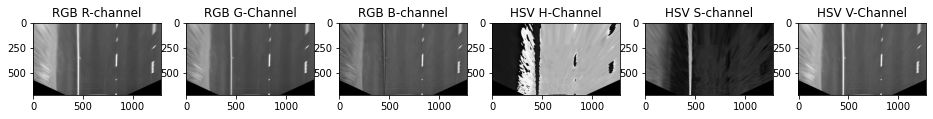

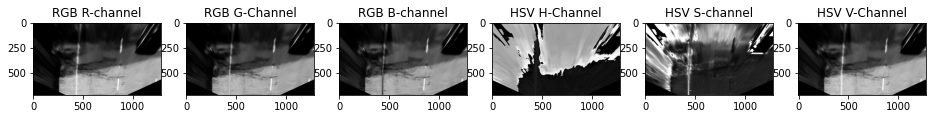

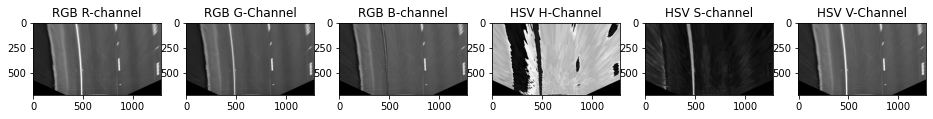

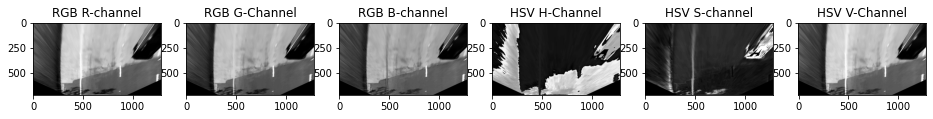

In [19]:
for img in warped_images:
    apply_color_filter(img)